In [37]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import joblib

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# # Algorithms
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.decomposition import PCA
# from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
# from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor, plot_importance, plot_tree

# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
sales_s = pd.read_pickle("sales_s.pkl")
sales_s.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-07-31,2244,10467,7204,19852,1865,3510,510,3849,1039
2014-08-31,1970,11319,7477,19164,2043,3804,524,3980,1134
2014-09-30,1877,10956,7592,17382,2188,3859,595,3787,1160
2014-10-31,1615,9822,7435,16034,2297,3823,636,3745,1180
2014-11-30,1796,10427,7434,16430,2432,3535,572,3861,1065


In [40]:
def double_exponential_smoothing(series, alpha=0.9, beta=0.9):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [41]:
month_in_year = 12
month_quarter =4
window1 = 3
window2 = 6
window3 = 12

def add_vars(y):
    df = y.copy()
    y_name = df.columns[0]
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
    df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)
    df['quarter_sin'] = np.sin(2*np.pi*df['quarter']/month_quarter)
    df['quarter_cos'] = np.cos(2*np.pi*df['quarter']/month_quarter)
    
    for i in range(1, 13):
        df[f"lag{i}"] = df[y_name].shift(i)
    df["Date"] = y[[y_name]].index
    
    df.reset_index(drop=True, inplace=True)

    df_rolled_3d = df[[y_name]].rolling(window=window1, min_periods=0)
    df_rolled_7d = df[[y_name]].rolling(window=window2, min_periods=0)
    df_rolled_30d = df[[y_name]].rolling(window=window3, min_periods=0)

    df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
    df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
    df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

    df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
    df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
    df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

    df[f"{y_name}_mean_lag{window1}"] = df_mean_3d[y_name]
    df[f"{y_name}_mean_lag{window2}"] = df_mean_7d[y_name]
    df[f"{y_name}_mean_lag{window3}"] = df_mean_30d[y_name]

    df[f"{y_name}_std_lag{window1}"] = df_std_3d[y_name]
    df[f"{y_name}_std_lag{window2}"] = df_std_7d[y_name]
    df[f"{y_name}_std_lag{window3}"] = df_std_30d[y_name]
    
    df[f"{y_name}_dbl_exp{'0.9, 0.9'}"] = pd.Series(double_exponential_smoothing(df[y_name])).shift(1)

    df.fillna(df.mean(), inplace=True)

    df.set_index("Date", drop=False, inplace=True)
    return df

In [42]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    return X_train, X_test, y_train, y_test

In [92]:
def add_vars_plus(df, test_size):
    """
        Add vars 
    """
    ts = df.copy()
    ts = add_vars(ts)
    y_name = ts.columns[0]
    y = ts.dropna()[y_name]
    X = ts.dropna().drop([y_name, 'Date'], axis=1)
    
    return X, y

In [93]:
scaler = StandardScaler()
def prepare_data(df, test_size=0.15):
    """
        Add vars & return X_train_scaled, X_test_scaled, y_train, y_test
    """
    X, y = add_vars_plus(df, test_size)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled)
    X_train_scaled.columns = X_train.columns
    X_test_scaled = pd.DataFrame(X_test_scaled)
    X_test_scaled.columns = X_train.columns
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [45]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [46]:
def excess_short(forecast, actual):
    epsilon = forecast - actual
    mape = np.mean(np.abs(epsilon)/np.abs(actual))
    exces_mask = epsilon>0
    short_mask = epsilon<0
    mape_exces = np.sum(np.abs(forecast[exces_mask] - actual[exces_mask])/np.abs(actual[exces_mask]))/len(forecast)
    mape_short = np.sum(np.abs(forecast[short_mask] - actual[short_mask])/np.abs(actual[short_mask]))/len(forecast)
    return 100*mape_exces/mape, 100*mape_short/mape

In [47]:
def forecast_accuracy(forecast, actual):
    assert len(forecast) == len(actual)
    mape = mean_absolute_percentage_error(actual, forecast)*100
    mae = mean_absolute_error(actual, forecast)   # MAE
    rmse = mean_squared_error(actual, forecast, squared=True)  # RMSE
    acf1 = acf(forecast-actual)[1]              # ACF1
    mape_exces, mape_short = excess_short(forecast, actual)
    return pd.Series({'mape':mape, 'mae': mae, 'rmse':rmse, 'mape_exces':mape_exces,'mape_short':mape_short})

In [48]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
def objective(space):
    # Instantiate the classifier
    clf = XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])
    
    eval_set  = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
    
    # Fit the classsifier
    clf.fit(X_train_scaled, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(X_test_scaled)
    
    # Calculate our Metric - accuracy
    accuracy = accuracy_score(y_test, pred>0.5)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

In [49]:
space ={'max_depth': hp.quniform("max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'gamma' : hp.uniform ('gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('reg_lambda', 0,1)
   }

In [50]:
def empty_df_like(df):
    return pd.DataFrame(columns=df.columns, index= df.index)

In [68]:
def get_tuned_xgb_for_df(df):
    """find best xgb model for each series in a data frame, returns dict of models"""
    models = {}
    for col in df.columns:
        global X_train_scaled, y_train, X_test_scaled, y_test
        X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(df[[col]])
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials)                
        best['max_depth'] = int(best['max_depth'])

        models[col] = XGBRegressor(n_estimators =1000, **best)
     
    return models

In [69]:
joblib_Filename = "joblib_XGB_sales_s_Models.joblib"
# if compress: joblib_Filename += '.z'
try:
    xgb_models = joblib.load(joblib_Filename)
    print("models imported")
except FileNotFoundError:
    xgb_models = get_tuned_xgb_for_df(sales_s) #fitting the model
    joblib.dump(xgb_models, joblib_Filename)
    print("models created and exported")

100%|██████████| 100/100 [00:12<00:00,  7.80trial/s, best loss: -0.0]
models created and exported


In [91]:
sales_s.iloc[0]

P_6      2244
P_22    10467
P_24     7204
P_30    19852
P_37     1865
P_38     3510
P_47      510
P_55     3849
P_64     1039
Name: 2014-07-31 00:00:00, dtype: int64

In [ ]:
def ML_dynamic_in_sample_forecast(series, models, test_size=0.15):
    test_index = int(len(series)*(1-test_size))
    n_models = len(models)
    models_errors = [pd.DataFrame(columns=series.columns, index=['mape', 'mae', 'rmse','mape_exces','mape_short']) for x in range(n_models)]
    models_predictions = [empty_df_like(series) for x in range(n_models)]
    models_lower = [empty_df_like(series) for x in range(n_models)]
    models_upper = [empty_df_like(series) for x in range(n_models)]


    test = [empty_df_like(sales_s) for x in range(2)]
    for i, col in enumerate(series.columns):
        X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(series[[col]],test_size)
        
        for j in range(n_models) :
            if "xgboost" in models[j][0] :
                if "tune" in models[j][0] :                    
                    models[j][1]= xgb_models[col]  

            
            for k in range(len(y_test)):
                models[j][1].fit(X_train_scaled, y_train)
                pred_pt= models[j][1].predict( X_test_scaled.iloc[0])
                X_train_scaled, y_train= add_vars_plus(pd.concat([y_train,pred_pt])
                

            models_predictions[j][col] 

            models_errors[j][col] = forecast_accuracy(models_predictions[j][col][test_index:], y_test)







            cv = cross_val_score(models[j][1], X_train_scaled, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
            mae = cv.mean() * (-1)
            deviation = cv.std()
            
            scale = 1.96
            models_lower[j][col] = models_predictions[j][col] - (mae + scale * deviation)
            models_upper[j][col] = models_predictions[j][col] + (mae + scale * deviation)
            
    models_predictions ={models[i][0]: pred for i, pred in enumerate(models_predictions)}
    models_lower = {models[i][0] : pred for i, pred in enumerate(models_lower)}
    models_upper = {models[i][0] : pred for i, pred in enumerate(models_upper)}
    models_errors = {models[i][0] : pred for i, pred in enumerate(models_errors)}

    return {'models_predictions' : models_predictions, 'models_lower' : models_lower, 'models_upper' : models_upper, 'models_errors': models_errors, 'test_index':test_index}
    

In [86]:
def ML_forecast(series, models, test_size=0.15):
    test_index = int(len(series)*(1-test_size))
    n_models = len(models)
    models_errors = [pd.DataFrame(columns=series.columns, index=['mape', 'mae', 'rmse','mape_exces','mape_short']) for x in range(n_models)]
    models_predictions = [empty_df_like(series) for x in range(n_models)]
    models_lower = [empty_df_like(series) for x in range(n_models)]
    models_upper = [empty_df_like(series) for x in range(n_models)]


    test = [empty_df_like(sales_s) for x in range(2)]
    for i, col in enumerate(series.columns):
        global X_train_scaled, y_train, X_test_scaled, y_test
        X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(series[[col]],test_size)
        if i==0 :     
            models_coeffs = [pd.DataFrame(columns=series.columns, index=X_train_scaled.columns) for x in range(n_models)]
        for j in range(n_models) :
            if "xgboost" in models[j][0] :
                if "tune" in models[j][0] :                    
                    models[j][1]= xgb_models[col]  

                models[j][1].fit(X_train_scaled, y_train, verbose=False)
                models_coeffs[j][col] = models[j][1].feature_importances_ 
            else : 
                models[j][1].fit(X_train_scaled, y_train)
                models_coeffs[j][col] = models[j][1].coef_
                
            # print( models[j][1])
            models_predictions[j][col] = models[j][1].predict(pd.concat([X_train_scaled, X_test_scaled]))
            # if col =='P_6':
            # print(models_predictions[j][col])
            models_errors[j][col] = forecast_accuracy(models_predictions[j][col][test_index:], y_test)

            cv = cross_val_score(models[j][1], X_train_scaled, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
            mae = cv.mean() * (-1)
            deviation = cv.std()
            
            scale = 1.96
            models_lower[j][col] = models_predictions[j][col] - (mae + scale * deviation)
            models_upper[j][col] = models_predictions[j][col] + (mae + scale * deviation)
            
    models_predictions ={models[i][0]: pred for i, pred in enumerate(models_predictions)}
    models_lower = {models[i][0] : pred for i, pred in enumerate(models_lower)}
    models_upper = {models[i][0] : pred for i, pred in enumerate(models_upper)}
    models_errors = {models[i][0] : pred for i, pred in enumerate(models_errors)}
    models_coeffs = {models[i][0] : pred for i, pred in enumerate(models_coeffs)}

    return {'models_predictions' : models_predictions, 'models_lower' : models_lower, 'models_upper' : models_upper, 'models_errors': models_errors, 'models_coeffs': models_coeffs, 'test_index':test_index}
    

In [ ]:
def ML_forecast(series, models, test_size=0.15):

In [54]:
def best_models(ML_forecast_res, criterion):
    df_template = lambda model_data : empty_df_like(list(ML_forecast_res[model_data].values())[0])
    best_predictions, models_lower, models_upper, models_errors, models_coeffs= \
        map(df_template, ('models_predictions', 'models_lower', 'models_upper', 'models_errors', 'models_coeffs'))

    # best_predictions = empty_df_like(list(ML_forecast_res['models_predictions'].values())[0])
    # models_lower = empty_df_like(list(ML_forecast_res['models_lower'].values())[0])
    # models_upper = empty_df_like(list(ML_forecast_res['models_upper'].values())[0])

    ML_forecast_error = {model_name : df.loc[criterion] for model_name ,df in  ML_forecast_res['models_errors'].items()}
    ML_forecast_error_df = pd.DataFrame(ML_forecast_error)

    best_models = ML_forecast_error_df.idxmin(axis=1)
    
    for col in best_predictions.columns :
       best_model = best_models[col]
       best_predictions[col] = ML_forecast_res['models_predictions'][best_model][col]
       models_lower[col] = ML_forecast_res['models_lower'][best_model][col]
       models_upper[col] = ML_forecast_res['models_upper'][best_model][col]
       models_errors[col] = ML_forecast_res['models_errors'][best_model][col]
       models_coeffs[col] = ML_forecast_res['models_coeffs'][best_model][col]

    return {'best_predictions': best_predictions, 'models_lower':models_lower, 'models_upper':models_upper, 'models_errors':models_errors, 'models_coeffs': models_coeffs, 'best_models':best_models, 'criterion': criterion, 'test_index':ML_forecast_res['test_index']}

    

In [55]:
def remove_axes(n_used_axes, all_axs):
    if n_used_axes%2 :
        all_axs = all_axs.flatten()
        size = len(all_axs)
        for useless_ax in all_axs.flatten()[-(size - n_used_axes):]:
            useless_ax.axis('off')

In [56]:
def plotCoefficients(model_coeff, features_names,model_name, item,axs):
    """
        Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model_coeff, features_names)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    axs.bar(coefs.index,coefs.coef)
    axs.tick_params(axis='x', labelrotation = 90)
    axs.grid(True, axis='y')
    axs.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    axs.set_title(f"{item}, Features importance of {'xgboost' if 'xgboost' in model_name else model_name}")



In [78]:
def plot_forecasts(forecast_data, df, plot_train_fc=False, plot_anomalies=True, plot_coeff=False):
    n_series = len(df.columns)
    test_index=forecast_data['test_index']
    fig_n_lines = ceil(n_series/2)
    # fig, axs = plt.subplots(fig_n_lines, 2 if n_series>1 else 1, figsize=(20, fig_n_lines*4))
    if n_series>1 : 
        fig, axs = plt.subplots(fig_n_lines, 2, figsize=(20, fig_n_lines*4))
        remove_axes(n_series, axs)
        axs = axs.flatten()
    else :
        fig, axs = plt.subplots(fig_n_lines, 1, figsize=(15, 7))
        axs = [axs]

    for i, item in enumerate(df.columns):
        axs[i].plot(df[item], label="actual")
        axs[i].plot(forecast_data['best_predictions'][item][0 if plot_train_fc else test_index:], color='darkgreen', label="forecast")
        axs[i].set_title(f"{item},  model : {'xgboost' if 'xgboost' in forecast_data['best_models'][item] else forecast_data['best_models'][item]},  {forecast_data['criterion']} : {forecast_data['models_errors'][item][forecast_data['criterion']]:.2f} { '%' if forecast_data['criterion']=='mape' else ''}")

        lower = forecast_data['models_lower'][item][test_index:]
        upper = forecast_data['models_upper'][item][test_index:]
        axs[i].plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        axs[i].plot(upper, "r--", alpha=0.5)
        
        y_test = df[item][test_index:]
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            anomalies_series = pd.Series(anomalies, index=y_test.index)
            if ~np.isnan(anomalies).all() : axs[i].plot(anomalies_series[-len(y_test):], "o", markersize=10, label = "Anomalies")
        
        axs[i].axvspan(lower.index[0], lower.index[-1],  color=sns.xkcd_rgb['grey'], alpha=0.2)

        axs[i].legend(loc="best")
    
    #plot features importance
    if plot_coeff :
        features_names=forecast_data['models_coeffs'].index
        if n_series>1 : 
            fig, axs = plt.subplots(fig_n_lines, 2, figsize=(16, fig_n_lines*5))
            
            remove_axes(n_series, axs)
            axs = axs.flatten()
        else :
            fig, axs = plt.subplots(fig_n_lines, 1, figsize=(13, 7))
            axs = [axs]

        for i, item in enumerate(df.columns):
            plotCoefficients(forecast_data['models_coeffs'][item], features_names, forecast_data['best_models'][item], item, axs[i])
            
        fig.tight_layout()


In [62]:
def full_forecast(series, models, test_size=0.15, criterion='mape', plot_train_fc=False, plot_anomalies=True, plot_coeff=False):
    ML_forecast_res = ML_forecast(sales_s, models, test_size)
    res = best_models(ML_forecast_res, criterion)
    plot_forecasts(res, series, plot_train_fc, plot_anomalies, plot_coeff)


In [63]:
lr = LinearRegression()
ridge = RidgeCV(cv=tscv)
lasso=LassoCV(cv=tscv)

In [70]:
ML_forecast_res = ML_forecast(sales_s, [["Lasso", lasso], ["Ridge", ridge]])


In [71]:
res = best_models(ML_forecast_res, 'mape')

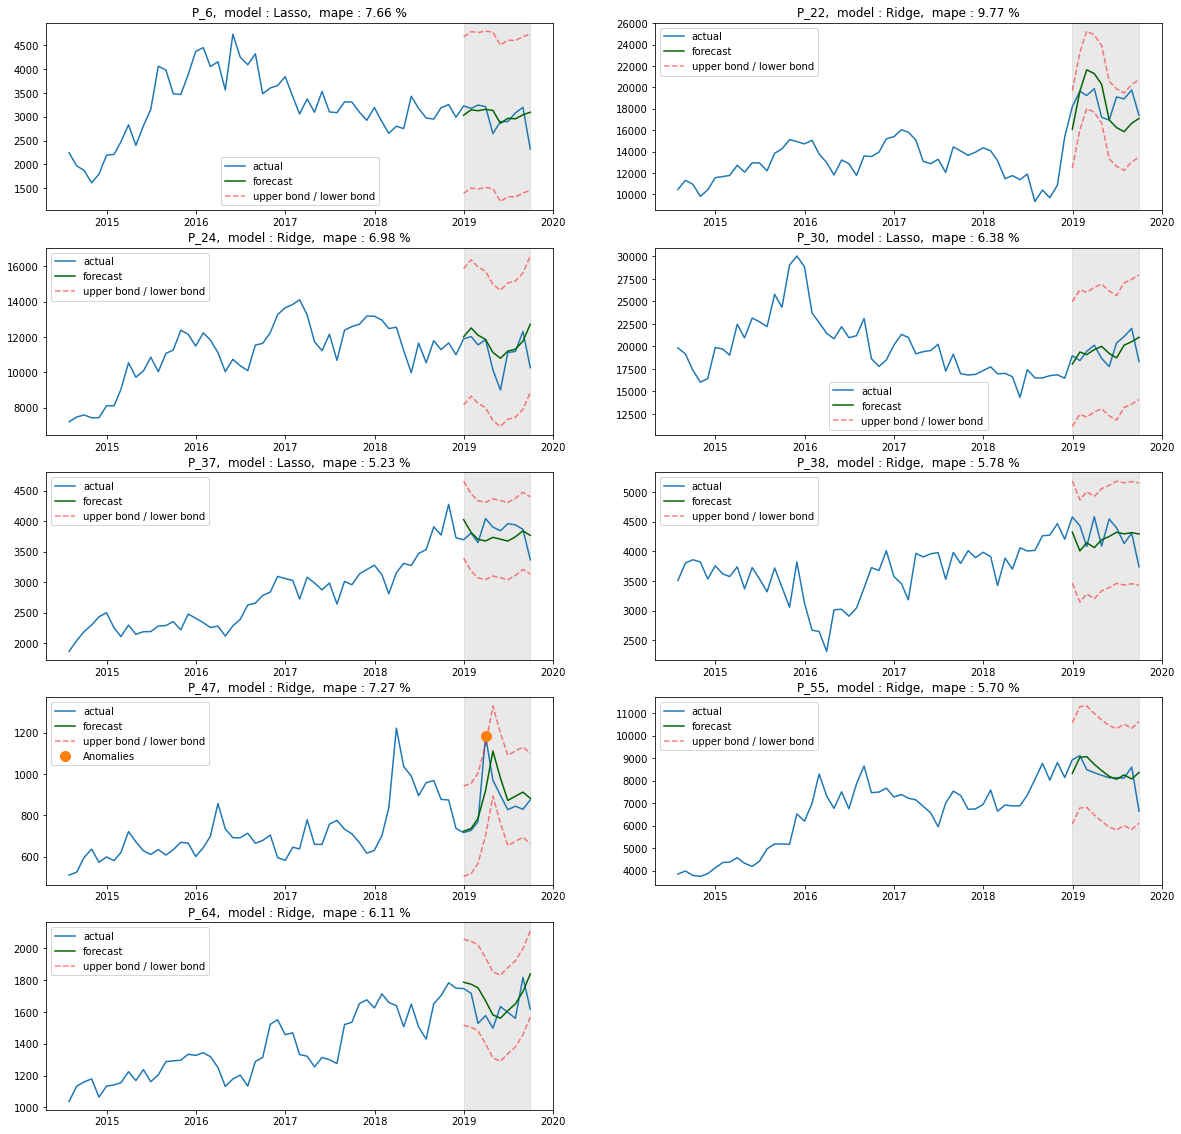

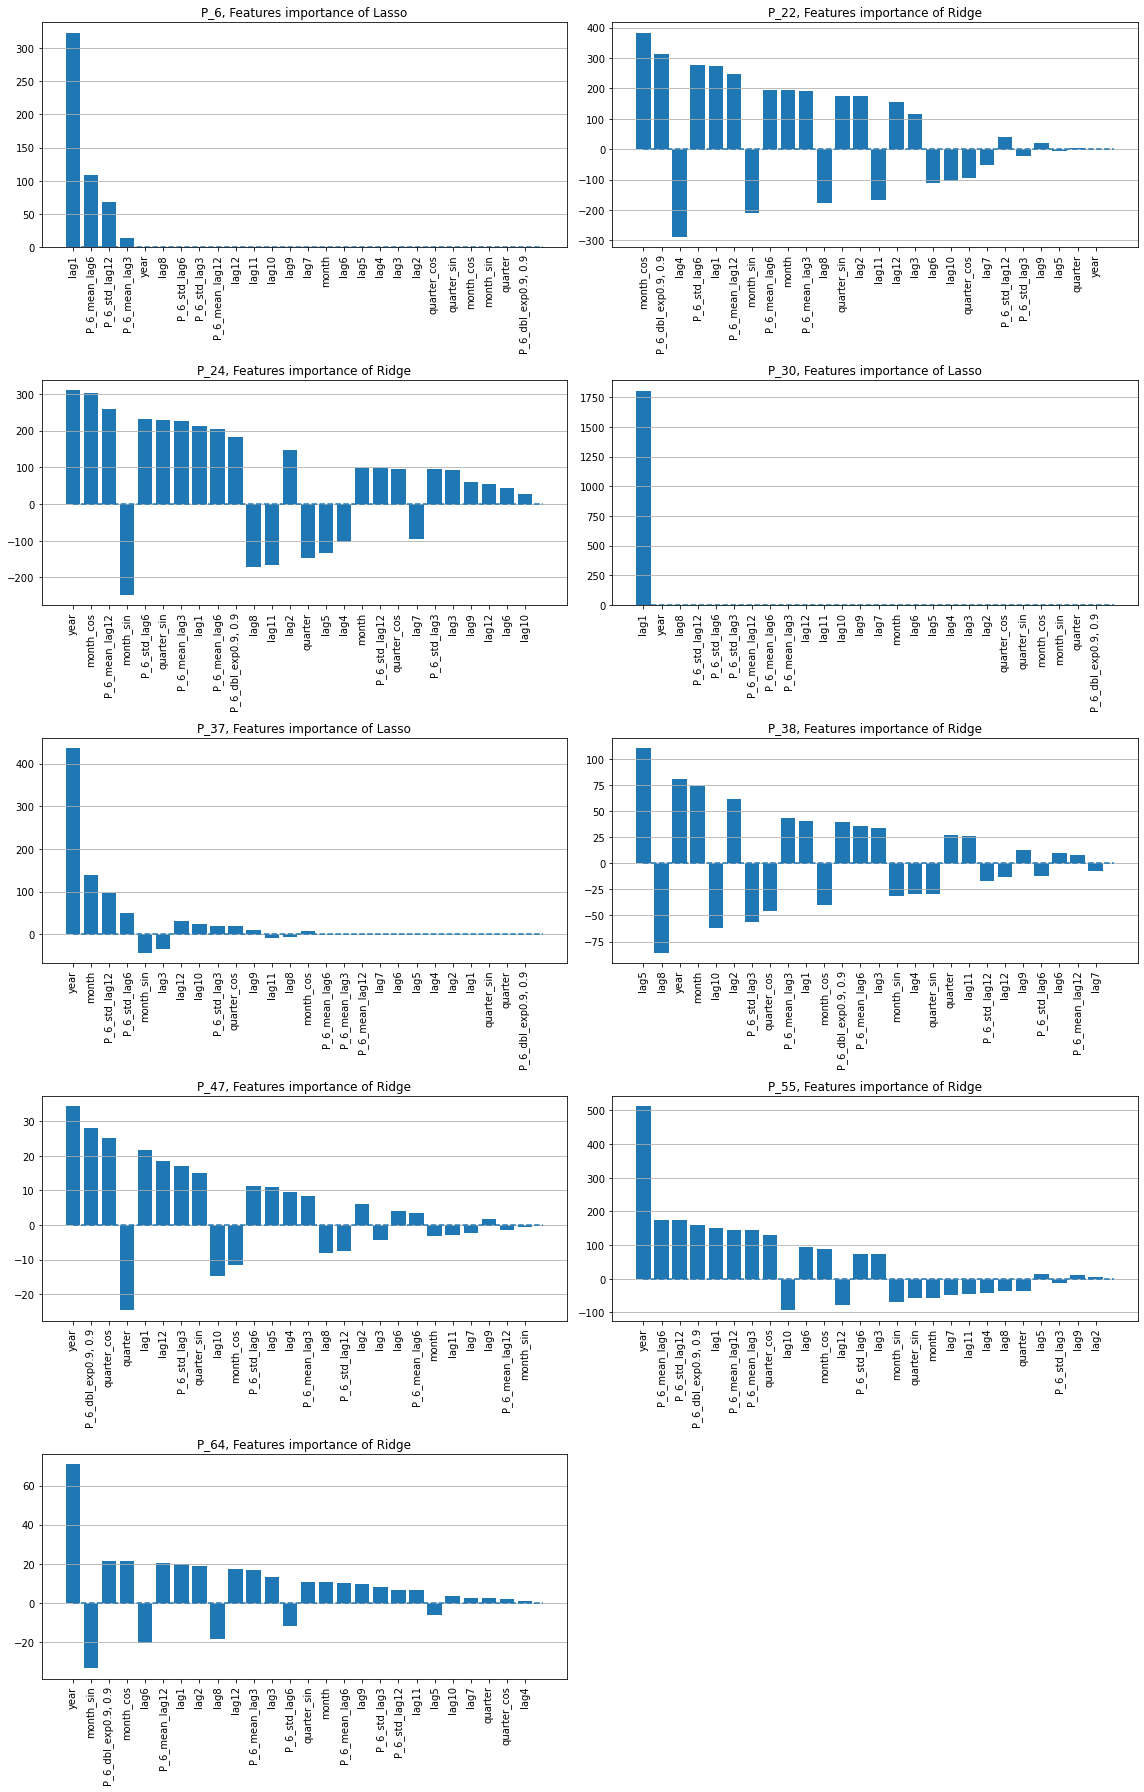

In [79]:
plot_forecasts(res, sales_s,plot_coeff=True)

Pour la démonstration de la demarche suivie dans l'apprentissage supervisé, on a selectionné aléatoirement un produit (P_64).


In [80]:
sales_s_p64 = sales_s[['P_64']]
sales_s_p64.head()

,P_64
2014-07-31,1039
2014-08-31,1134
2014-09-30,1160
2014-10-31,1180
2014-11-30,1065



On a commencé par implémenter le concept de "feature engineering" ou on a généré les variables nécessaires pour entrainer les modèles d'apprentissage.

- Variables de temps : année, mois, trimestre
- Valeurs retardées des séries temporelles
- Statistiques : la moyenne et l'écart type des valeurs retardées. 

titre : Visualisation des variables cycliques 

Les variables temporelles tels que le mois et le trimestre sont cycliques. Par exemple, le mois oscille entre 1 et 12 pour chaque année. Alors que la différence entre chaque mois augmente de 1 au cours de l'année, entre deux ans, la caractéristique du mois passe de 12 (décembre) à 1 (janvier). Il en résulte une différence de -11, ce qui peut dérouter beaucoup de modèles.


Pour résoudre ce problème, on a effectué une transformation par la fonction cosinus après avoir normalisé les variables entre 0 et 2π, ce qui correspond à un cycle de cosinus, cette solution ne régle pas le problème complétement car deux valeurs différentes peuvent avoir la même image par la fonction cosinus. La meilleure façon de résoudre ce nouveau problème était d'ajouter une autre information cyclique pour distinguer deux temps avec des valeurs de cosinus identiques, il s'agit de la fonction sinus. Nous pourrions le considérer comme un système de coordonnées à deux axes.

In [ ]:
demo = sales_s_p64.copy()
demo['year'] = demo.index.year
demo['month'] = demo.index.month
demo['quarter'] = demo.index.quarter
demo.tail()

,P_64,year,month,quarter
2019-05-31,1634,2019,5,2
2019-06-30,1597,2019,6,2
2019-07-31,1560,2019,7,3
2019-08-31,1817,2019,8,3
2019-09-30,1618,2019,9,3


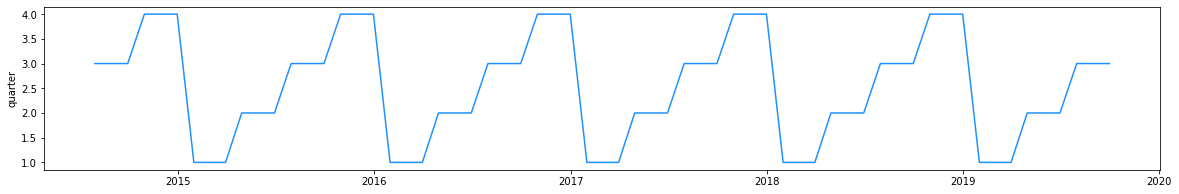

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(x=demo.index, y=demo['quarter'], color='dodgerblue')
# ax.set_xlim(["2014-07-31", "2019-09-30"])
plt.show()

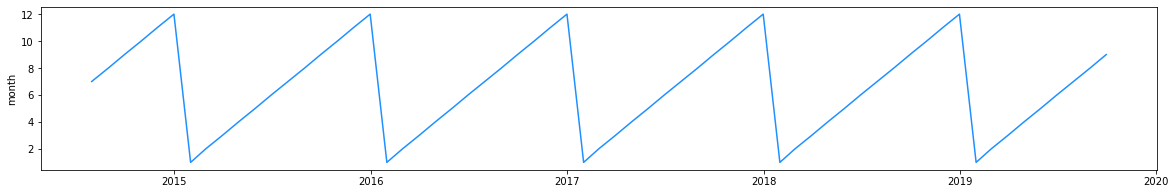

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(x=demo.index, y=demo['month'], color='dodgerblue')
# ax.set_xlim(["2014-07-31", "2019-09-30"])
plt.show()

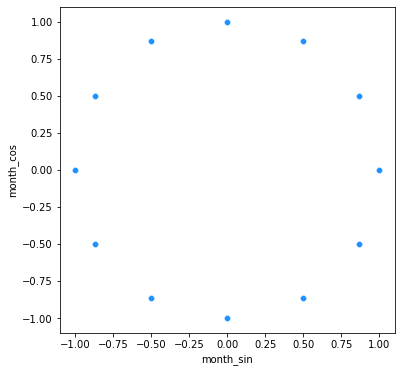

In [ ]:
month_in_year = 12
demo['month_sin'] = np.sin(2*np.pi*demo['month']/month_in_year)
demo['month_cos'] = np.cos(2*np.pi*demo['month']/month_in_year)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.scatterplot(x=demo.month_sin, y=demo.month_cos, color='dodgerblue')
plt.show()

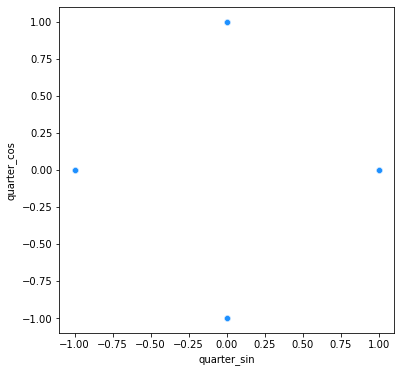

In [ ]:
month_quarter =4
demo['quarter_sin'] = np.sin(2*np.pi*demo['quarter']/month_quarter)
demo['quarter_cos'] = np.cos(2*np.pi*demo['quarter']/month_quarter)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.scatterplot(x=demo.quarter_sin, y=demo.quarter_cos, color='dodgerblue')
plt.show()

In [ ]:
demo.head()

,P_64,year,month,quarter,month_sin,month_cos,quarter_sin,quarter_cos
2014-07-31,1039,2014,7,3,-0.500000,-8.660254e-01,-1.000000e+00,-1.836970e-16
2014-08-31,1134,2014,8,3,-0.866025,-5.000000e-01,-1.000000e+00,-1.836970e-16
2014-09-30,1160,2014,9,3,-1.000000,-1.836970e-16,-1.000000e+00,-1.836970e-16
2014-10-31,1180,2014,10,4,-0.866025,5.000000e-01,-2.449294e-16,1.000000e+00
2014-11-30,1065,2014,11,4,-0.500000,8.660254e-01,-2.449294e-16,1.000000e+00


Comme indiqué précédemment, on a utilisé les variables de la série décalées pour beneficier de l'autocorrélation existante dans la série. Pour prendre en compte l'effet de la saisonnalité, on a considéré 12 retards.

In [ ]:
for i in range(1, 13):
    demo[f"lag{i}"] = demo.P_64.shift(i)

In [ ]:
demo2 = demo.copy()
demo2["Date"] = demo[['P_64']].index

On a généré les moyennes mobiles et ecart-types mobiles (trimestrielle, semestrielle et annuelle) des valeurs décalées afin de détecter la tendance globale des données.

In [ ]:
demo2.reset_index(drop=True, inplace=True)
window1 = 3
window2 = 6
window3 = 12

df_rolled_3d = demo2[["P_64"]].rolling(window=window1, min_periods=0)
df_rolled_7d = demo2[["P_64"]].rolling(window=window2, min_periods=0)
df_rolled_30d = demo2[["P_64"]].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

demo2[f"{'P_64'}_mean_lag{window1}"] = df_mean_3d["P_64"]
demo2[f"{'P_64'}_mean_lag{window2}"] = df_mean_7d["P_64"]
demo2[f"{'P_64'}_mean_lag{window3}"] = df_mean_30d["P_64"]

demo2[f"{'P_64'}_std_lag{window1}"] = df_std_3d["P_64"]
demo2[f"{'P_64'}_std_lag{window2}"] = df_std_7d["P_64"]
demo2[f"{'P_64'}_std_lag{window3}"] = df_std_30d["P_64"]

demo2[f"{'P_64'}_dbl_exp{'0.9, 0.9'}"] = pd.Series(double_exponential_smoothing(demo2["P_64"])).shift(1)


demo2.fillna(demo2.mean(), inplace=True)

demo2.set_index("Date", drop=True, inplace=True)
demo2.head()

,P_64,year,month,quarter,month_sin,month_cos,quarter_sin,quarter_cos,lag1,lag2,...,lag10,lag11,lag12,P_64_mean_lag3,P_64_mean_lag6,P_64_mean_lag12,P_64_std_lag3,P_64_std_lag6,P_64_std_lag12,"P_64_dbl_exp0.9, 0.9"
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-31,1039,2014,7,3,-0.500000,-8.660254e-01,-1.000000e+00,-1.836970e-16,1406.209677,1399.47541,...,1368.113208,1360.788462,1352.509804,1395.29834,1382.994995,1358.878906,60.828255,81.603775,99.325943,1417.90477
2014-08-31,1134,2014,8,3,-0.866025,-5.000000e-01,-1.000000e+00,-1.836970e-16,1039.000000,1399.47541,...,1368.113208,1360.788462,1352.509804,1039.00000,1039.000000,1039.000000,60.828255,81.603775,99.325943,1039.00000
2014-09-30,1160,2014,9,3,-1.000000,-1.836970e-16,-1.000000e+00,-1.836970e-16,1134.000000,1039.00000,...,1368.113208,1360.788462,1352.509804,1086.50000,1086.500000,1086.500000,67.175148,67.175148,67.175148,1229.00000
2014-10-31,1180,2014,10,4,-0.866025,5.000000e-01,-2.449294e-16,1.000000e+00,1160.000000,1134.00000,...,1368.113208,1360.788462,1352.509804,1111.00000,1111.000000,1111.000000,63.694584,63.694584,63.694584,1206.01000
2014-11-30,1065,2014,11,4,-0.500000,8.660254e-01,-2.449294e-16,1.000000e+00,1180.000000,1160.00000,...,1368.113208,1360.788462,1352.509804,1158.00000,1128.250000,1128.250000,23.065125,62.409267,62.409267,1200.64290


Pour la validation des modèles on a divisé le jeu de données en deux parties : la premiere partie pour l'entrainement du modèle (train set) et le reste (la derniere année) est reservé pour l'évaluation.

On a ajusté un modèle de regression linéaire multiple sur l'ensemble des variables et on a obtenu une erreur (MAPE) de 5.29% sur le test set.

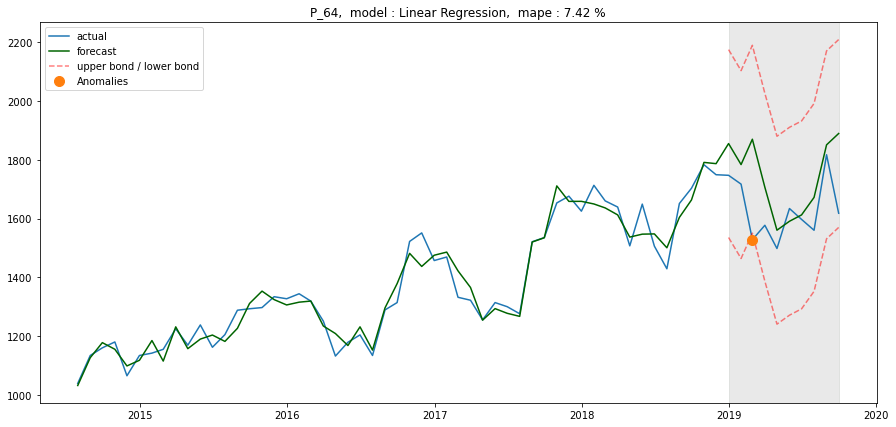

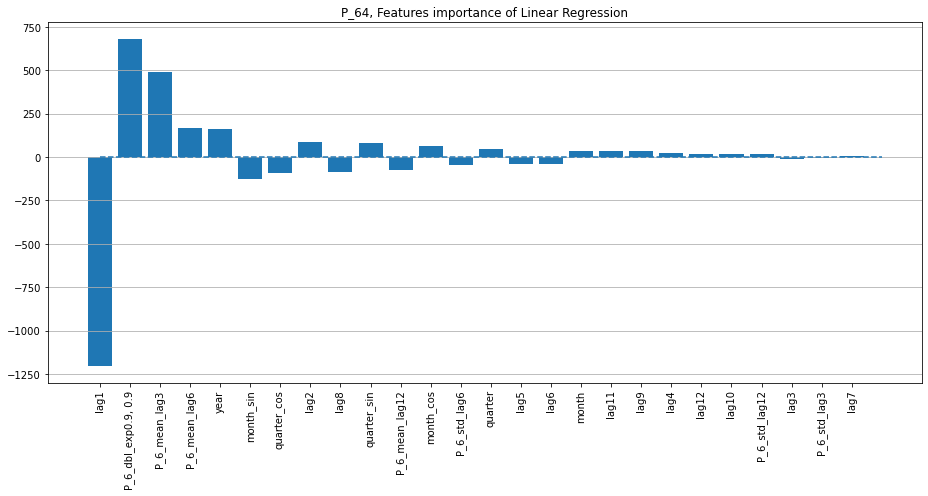

In [81]:
full_forecast(sales_s_p64, [["Linear Regression", lr]], plot_train_fc=True, plot_coeff=True)

Ce premier modèle présente des défauts

La régression linéaire a donné des résultats assez biens. Cependant ce modèle simple présente des défauts,certaines variables explicatives sont fortement corrélées et toutes les variables ne sont pas également saines,certaines peuvent entraîner un surapprentissage tandis que d'autres doivent être supprimées.

- le modèle n'arrive pas à utiliser toute l'information disponible aux varibales explicatives ??

D'autre part, puisque on a différentes échelles dans les variables, celles ci doivent etre transformées en une même échelle pour explorer l'importance des caractéristiques et, plus tard, la régularisation.

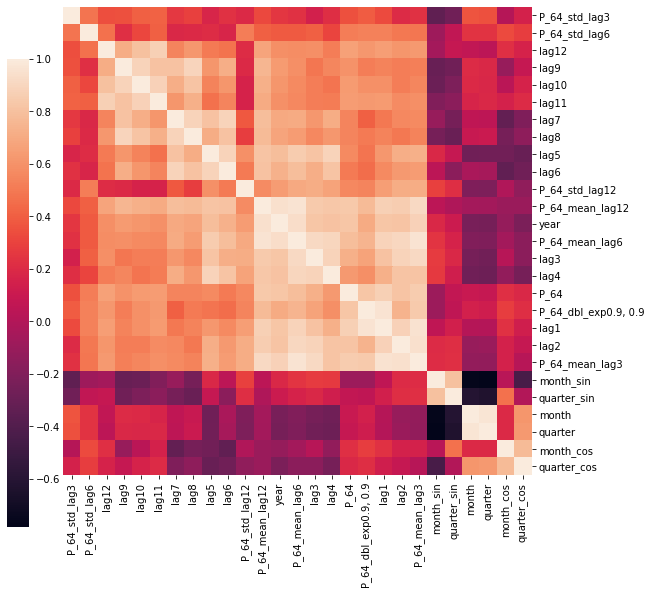

In [ ]:
cg = sns.clustermap(demo2.corr(), figsize=(10, 10), cbar_pos=(.1, .1, .03, .65))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
plt.show()

Pour une meilleure optimisation des variables explicatives, on a  appliqué la régularisation. Deux des modèles de régression avec régularisation les plus populaires sont les régressions Ridge et Lasso. Ils ajoutent tous deux des contraintes supplémentaires à notre fonction de perte.

Dans le cas de la régression Ridge, ces contraintes sont la somme des carrés des coefficients multipliée par le coefficient de régularisation. Plus le coefficient d'une caractéristique est grand, plus notre perte sera importante. Par conséquent, nous essaierons d'optimiser le modèle tout en gardant les coefficients assez bas.

À la suite de cette régularisation L2, nous aurons un biais plus élevé et une variance plus faible, donc le modèle se généralisera mieux.

Le deuxième modèle de régression, la régression Lasso, ajoute à la fonction de perte, non pas des carrés, mais des valeurs absolues des coefficients. Par conséquent, au cours du processus d'optimisation, les coefficients des caractéristiques sans importance peuvent devenir des zéros, ce qui permet une sélection automatisée des caractéristiques. Ce type de régularisation est appelé L1.

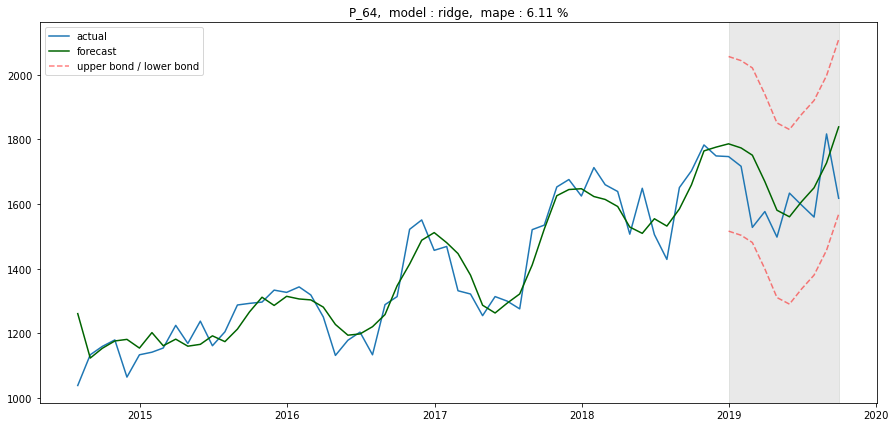

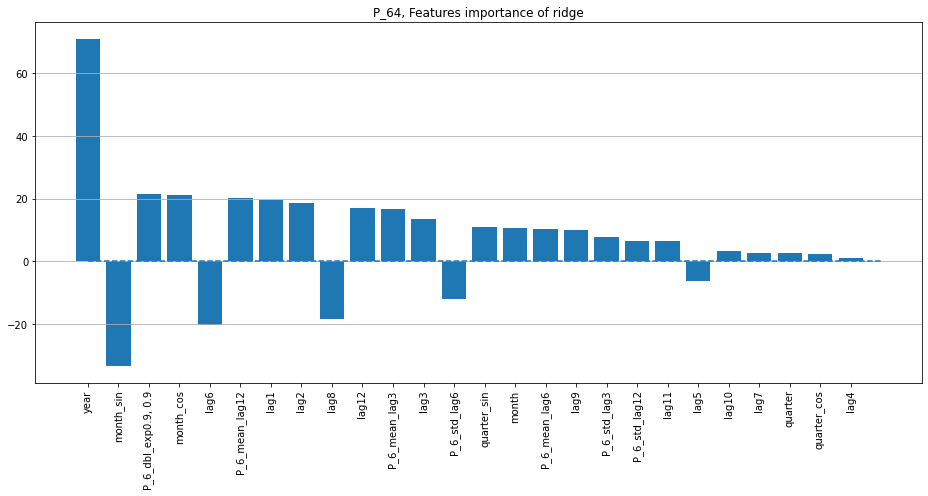

In [82]:
full_forecast(sales_s_p64, [["ridge", ridge]], plot_train_fc=True, plot_coeff=True)

La figure ci-dessous représente les prévisions pour chaque produit par le modèle qui minimise l'erreur (MAPE) parmis les deux modèles de régularisation.

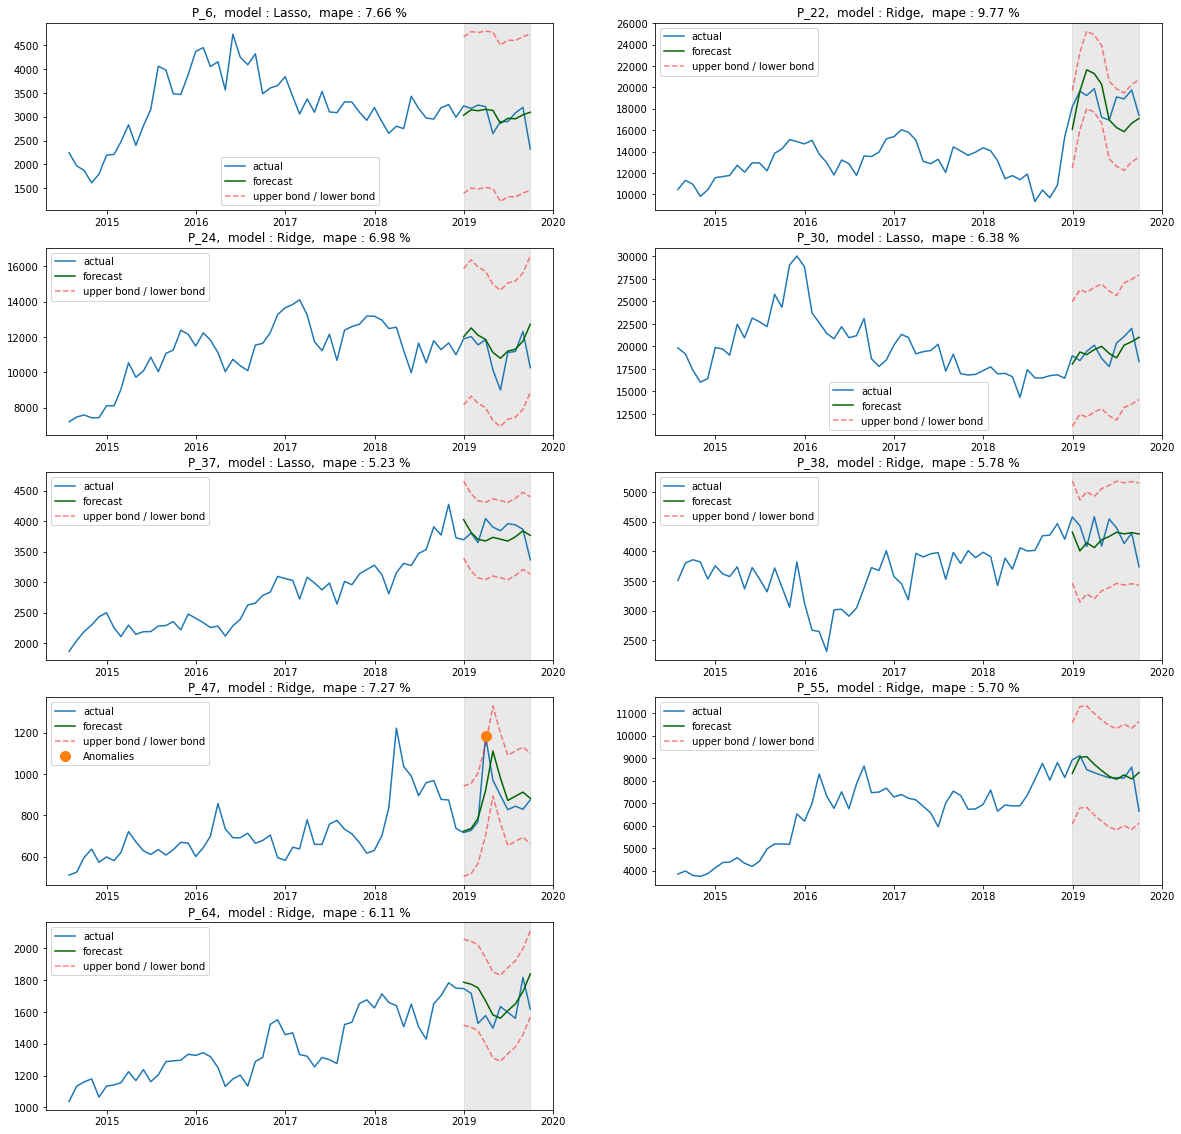

In [83]:

full_forecast(sales_s, [["Lasso", lasso], ["Ridge", ridge]] )


In [84]:
best = {'colsample_bytree': 0.7855436372368847,
 'gamma': 0.2715026337470021,
 'max_depth': 11,
 'min_child_weight': 1.0,
 'reg_lambda': 0.358974472027333,
 'subsample': 0.8129759325416941}

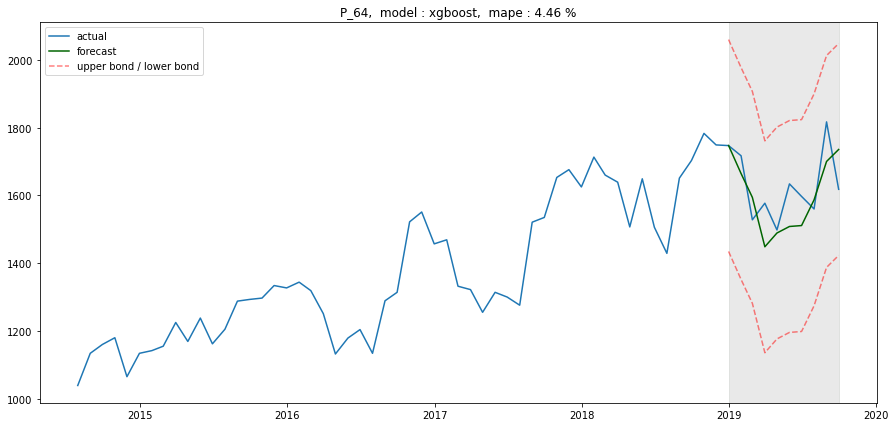

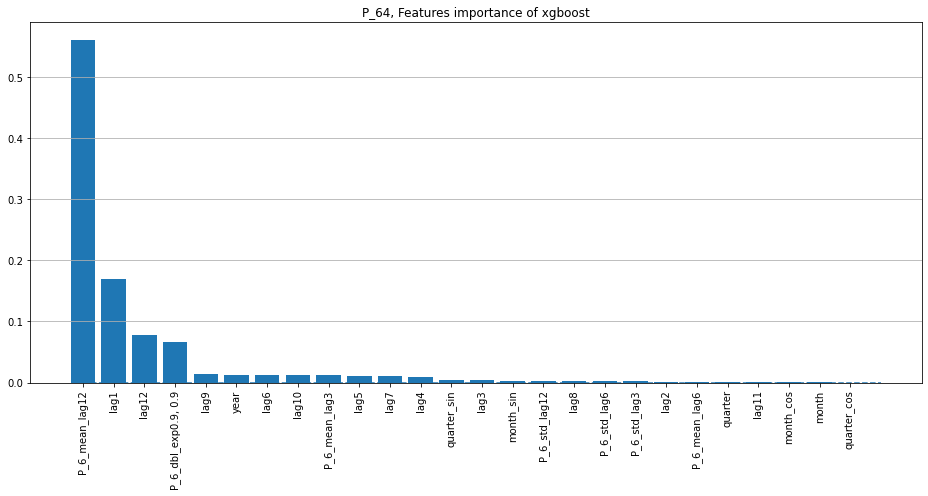

In [87]:
reg=XGBRegressor(n_estimators =1000, **best)
full_forecast(sales_s_p64, [["default_xgboost", reg]],plot_coeff=True )

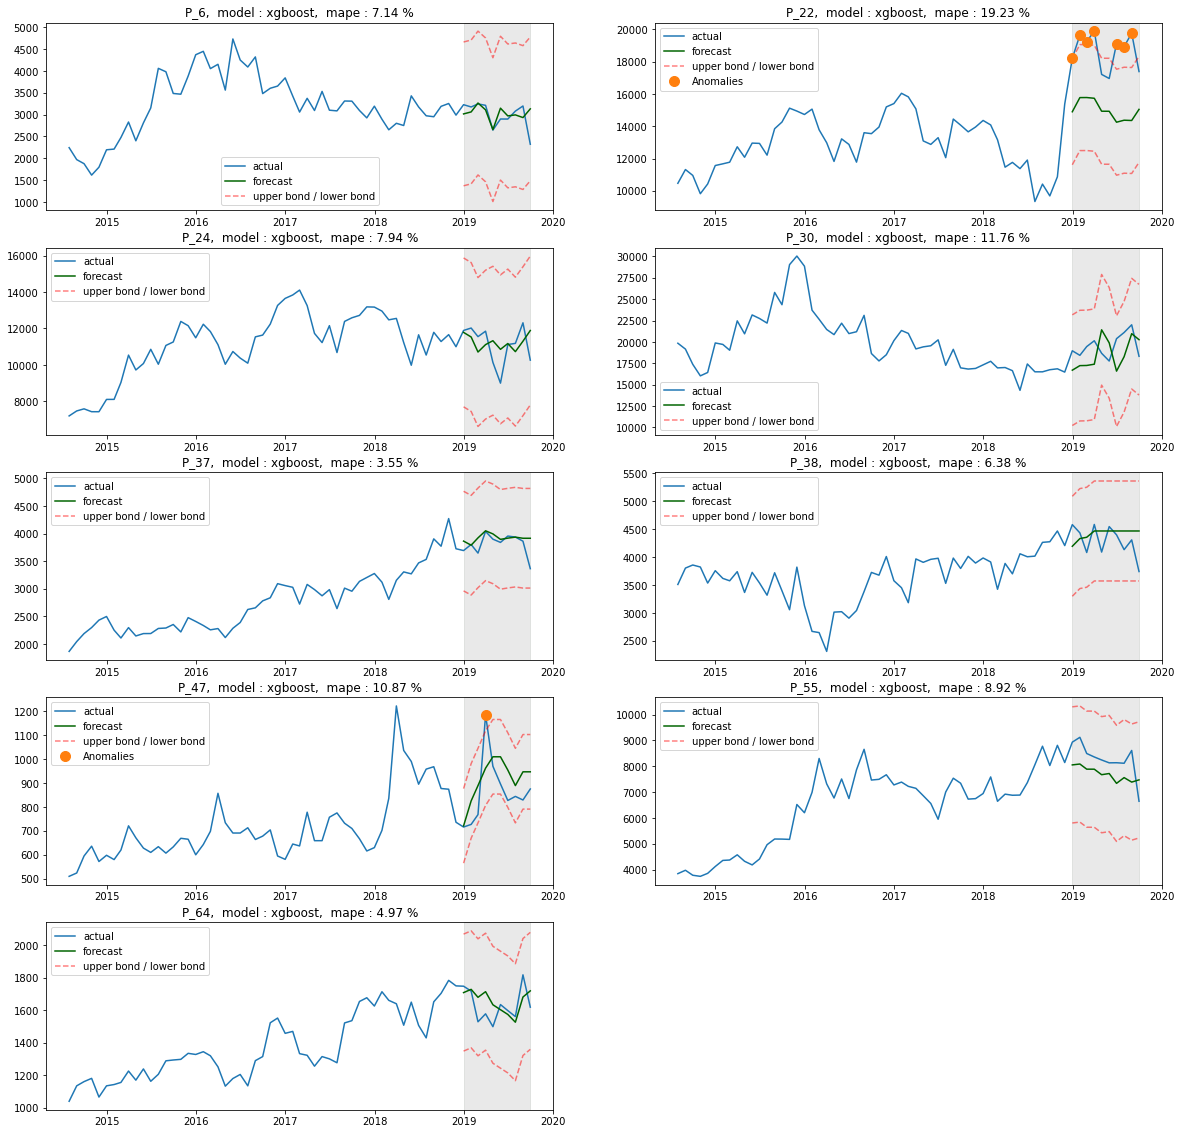

In [88]:
full_forecast(sales_s, [["tuned_xgboost", 0], ["default_xgboost", XGBRegressor(n_estimators =1000)]])

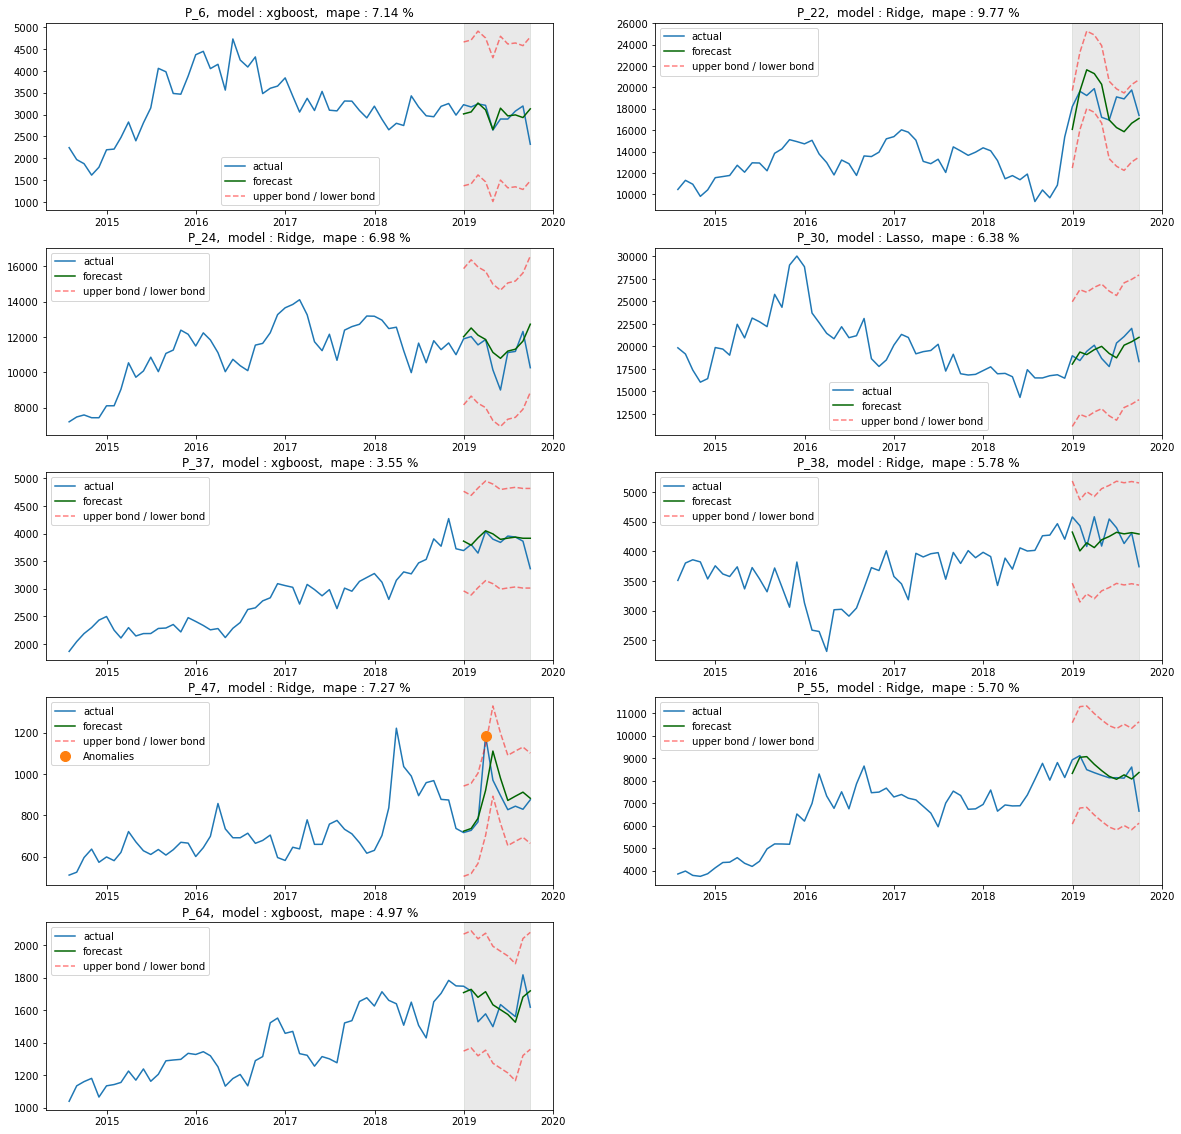

In [89]:
full_forecast(sales_s, [["tuned_xgboost", 0], ["default_xgboost", XGBRegressor(n_estimators =1000)],\
                                 ["Lasso", lasso], ["Ridge", ridge]])